In [83]:
import pandas as pd
import spacy
import os
from importlib import reload

In [84]:
import source.prepare_data as prd
import source.dataset as dat
import source.multi_layer_perceptron as mlp
import source.table as tb
import source.comparision as comp
import source.recurent_neural_networks as rnn

In [85]:
reload(prd)
reload(dat)
reload(mlp)
reload(tb)
reload(comp)
reload(rnn)

<module 'source.recurent_neural_networks' from 'C:\\Python_files\\DL_final2\\source\\recurent_neural_networks.py'>

In [86]:
# set your path
os.chdir("C:\Python_files\DL_final2")
os.getcwd()

'C:\\Python_files\\DL_final2'

In [87]:
"""
1) Preprocessing
"""
# load models and dataset
df = pd.read_csv("hf://datasets/gxb912/large-twitter-tweets-sentiment/train.csv", nrows=10000)
nlp = spacy.load("en_core_web_sm")

# prepare dataset
df = prd.prepare_df(df, nlp)

# create dataset out of cleaned columns
dataset = dat.Text_Dataset(df, col_text="clean_text_str", col_label="sentiment", args={"max_features":5000})
dataset.split_dataset()


In [88]:
df

,sentiment,clean_text,clean_text_str,text
0,1,"[love, you, toooooo, TG, LOL, Gngb]",love you toooooo TG LOL Gngb,@tonigirl14 love you toooooo ! ! TG LOL Gngb
1,0,"[I, tell, myself, do, click, on, this, link, b...",I tell myself do click on this link but I just...,@jun6lee I told myself : Do n't click on this ...
2,0,"[the, man, who, render, his, voice, to, Mickey...",the man who render his voice to Mickey Mouse e...,The man who rendered his voice to Mickey Mouse...
3,1,"[I, think, red, would, be, nice, or, maybe, yo...",I think red would be nice or maybe you could d...,@Shontelle_Layne I think red would be nice . ...
4,0,"[I, guess, one, of, her, tweet, say, she, be, ...",I guess one of her tweet say she be confused,@Silverlines - I guess . 'Cause one of her twe...
...,...,...,...,...
9995,0,"[aww, what, wrong, love, anyway, I, okay, well...",aww what wrong love anyway I okay well Haay,@kateistheshizz aww what 's wrong love ? any...
9996,0,"[on, half, my, throat, that, would, suck]",on half my throat that would suck,@somfan on half my throat ? That would suck .
9997,1,"[good, morning, greet, from, sunny, Greece]",good morning greet from sunny Greece,"@mariakitano Good morning , greeting from sunn..."
9998,1,"[Callig, Bry, pm, in, hour, min, tonight]",Callig Bry pm in hour min tonight,"Callig Bry @ 8 pm ( in 3 hours , 35 mins ! ) t..."


In [89]:
"""
2) Accuracy analysis for MLP model. We will compare the workflow of MLP by using TD-IDF encoding and BOW encoding

2.1) TD-IDF encoding
"""
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = dataset.get_encodings(tdidf=True)

mlp_tdidf_params = mlp.find_best_mlp(X_train=X_train_TF,
                                      Y_train=Y_train_TF,
                                      X_test=X_test_TF,
                                      Y_test=Y_test_TF,
                                      n_trials = 10,
                                     encoding='TDIDF')

mlp_tdidf_params.to_pickle("checkpoints\mlp_tdidf_params.pkl")

# load the dataframe
# mlp_tdidf_params = pd.read_pickle("checkpoints\mlp_tdidf_params.pkl")

[I 2025-06-20 18:22:40,981] A new study created in memory with name: mlp_optimization
[I 2025-06-20 18:23:06,355] Trial 0 finished with values: [0.6444564461708069, 0.7095000147819519] and parameters: {'epochs': 166, 'learning_rate': 0.10473119949052631, 'units': 8}.
[I 2025-06-20 18:23:32,478] Trial 1 finished with values: [1.1306217908859253, 0.7080000042915344] and parameters: {'epochs': 178, 'learning_rate': 0.4740132680608405, 'units': 4}.
[I 2025-06-20 18:24:02,357] Trial 2 finished with values: [0.533395528793335, 0.7304999828338623] and parameters: {'epochs': 200, 'learning_rate': 0.045151405590688004, 'units': 7}.
[I 2025-06-20 18:24:22,120] Trial 3 finished with values: [0.7854697704315186, 0.6924999952316284] and parameters: {'epochs': 130, 'learning_rate': 0.19001378476306788, 'units': 7}.
[I 2025-06-20 18:24:38,977] Trial 4 finished with values: [0.6154868006706238, 0.7160000205039978] and parameters: {'epochs': 111, 'learning_rate': 0.14088573116718187, 'units': 8}.
[I 20

In [90]:
mlp_tdidf_params

,loss,accuracy,params_epochs,params_learning_rate,params_units,time,trial_time,name
0,0.966844,0.6795,132,0.382973,3,20.206940,20.206940,MLP_TDIDF
1,0.785470,0.6925,130,0.190014,7,19.763185,19.763185,MLP_TDIDF
2,0.955685,0.6980,143,0.351650,9,24.495364,24.495364,MLP_TDIDF
3,0.912543,0.7020,138,0.282411,6,21.133728,21.133728,MLP_TDIDF
4,0.754808,0.7075,106,0.244987,6,17.013422,17.013422,MLP_TDIDF
5,1.130622,0.7080,178,0.474013,4,26.121225,26.121225,MLP_TDIDF
6,0.644456,0.7095,166,0.104731,8,25.373619,25.373619,MLP_TDIDF
7,0.549058,0.7145,108,0.034657,4,16.308757,16.308757,MLP_TDIDF
8,0.615487,0.7160,111,0.140886,8,16.855306,16.855306,MLP_TDIDF
9,0.533396,0.7305,200,0.045151,7,29.877367,29.877367,MLP_TDIDF


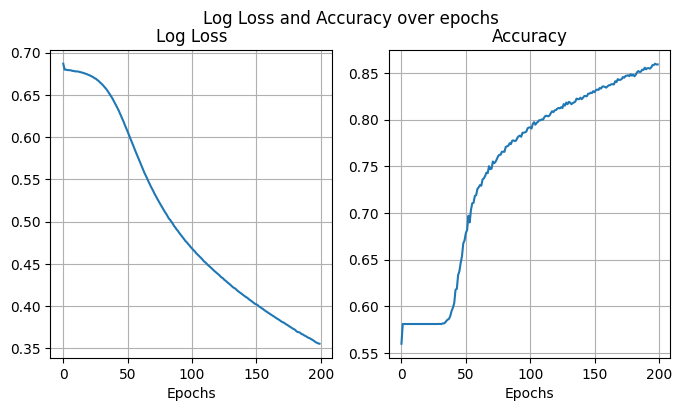

In [91]:
mlp_tdidf = mlp.Feedforward_Model(X_train_TF, Y_train_TF, units=mlp_tdidf_params.iloc[-1]['params_units']) # the last one is the best one
mlp_tdidf.train(LR=mlp_tdidf_params.iloc[-1]['params_learning_rate'], epochs=mlp_tdidf_params.iloc[-1]['params_epochs'])
mlp_tdidf.plot_loss_accuracy()

In [92]:
# Do some tests for vocab size
mlp_tdidf_vocab = comp.test_vocab_size(df,
                                     "MLP",
                                     "TDIDF",
                                     learning_rate=mlp_tdidf_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_tdidf_params.iloc[-1]['params_epochs'],
                                     units=mlp_tdidf_params.iloc[-1]['params_units'])

Initializing vocab-size test for MLP, with embedding TDIDF.
Params: 0.045151405590688004, 200, 7
Test started........
The result is: [(1000, 0.74), (2000, 0.7455), (3000, 0.7365), (4000, 0.757), (5000, 0.735), (6000, 0.7455), (7000, 0.7365), (8000, 0.744)]


In [93]:
# Tests for split ratio
mlp_tdidf_split = comp.test_split_ratio(dataset,
                                     "MLP",
                                     "TDIDF",
                                     learning_rate=mlp_tdidf_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_tdidf_params.iloc[-1]['params_epochs'],
                                     units=mlp_tdidf_params.iloc[-1]['params_units'])

Initializing split test for MLP, with embedding TDIDF.
Params: 0.045151405590688004, 200, 7
Test started.....
The result is: [(0.1, 0.742), (0.2, 0.756), (0.3, 0.748), (0.4, 0.734), (0.5, 0.7364)]


In [94]:
"""
2.2) BOW encoding
"""
X_train_BOW, X_test_BOW, Y_train_BOW, Y_test_BOW = dataset.get_encodings(tdidf=False)

mlp_bow_params = mlp.find_best_mlp(X_train=X_train_BOW,
                                      Y_train=Y_train_BOW,
                                      X_test=X_test_BOW,
                                      Y_test=Y_test_BOW,
                                      n_trials = 10)

mlp_bow_params.to_pickle("checkpoints\mlp_bow_params.pkl")
# mlp_bow_params = pd.read_pickle("checkpoints\mlp_bow_params.pkl")

[I 2025-06-20 18:33:03,711] A new study created in memory with name: mlp_optimization
[I 2025-06-20 18:33:20,153] Trial 0 finished with values: [1.5061302185058594, 0.6940000057220459] and parameters: {'epochs': 140, 'learning_rate': 0.3446617702055035, 'units': 6}.
[I 2025-06-20 18:33:33,157] Trial 1 finished with values: [1.3174422979354858, 0.6990000009536743] and parameters: {'epochs': 111, 'learning_rate': 0.329467440559921, 'units': 6}.
[I 2025-06-20 18:33:49,032] Trial 2 finished with values: [1.2788612842559814, 0.7026000022888184] and parameters: {'epochs': 137, 'learning_rate': 0.2543443310269257, 'units': 3}.
[I 2025-06-20 18:34:02,502] Trial 3 finished with values: [1.2721314430236816, 0.699999988079071] and parameters: {'epochs': 117, 'learning_rate': 0.30411285248563064, 'units': 3}.
[I 2025-06-20 18:34:23,703] Trial 4 finished with values: [0.6736514568328857, 0.72079998254776] and parameters: {'epochs': 188, 'learning_rate': 0.04593174304947705, 'units': 5}.
[I 2025-06-

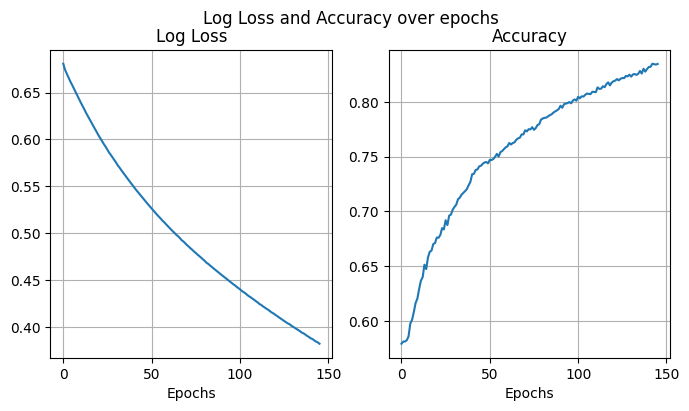

In [95]:
mlp_bow = mlp.Feedforward_Model(X_train_BOW, Y_train_BOW, units=mlp_bow_params.iloc[-1]['params_units'])
mlp_bow.train(LR=mlp_bow_params.iloc[-1]['params_learning_rate'], epochs=mlp_bow_params.iloc[-1]['params_epochs'])
mlp_bow.plot_loss_accuracy()

In [96]:
# Do some tests for vocab size
mlp_bow_vocab = comp.test_vocab_size(df,
                                     "MLP",
                                     "BOW",
                                     learning_rate=mlp_bow_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_bow_params.iloc[-1]['params_epochs'],
                                     units=mlp_bow_params.iloc[-1]['params_units'])

Initializing vocab-size test for MLP, with embedding BOW.
Params: 0.023971889736978877, 146, 9
Test started........
The result is: [(1000, 0.7385), (2000, 0.74), (3000, 0.738), (4000, 0.7405), (5000, 0.7485), (6000, 0.7475), (7000, 0.7355), (8000, 0.7435)]


In [97]:
# Tests for split ratio
mlp_bow_split = comp.test_split_ratio(dataset,
                                     "MLP",
                                     "BOW",
                                     learning_rate=mlp_bow_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_bow_params.iloc[-1]['params_epochs'],
                                     units=mlp_bow_params.iloc[-1]['params_units'])

Initializing split test for MLP, with embedding BOW.
Params: 0.023971889736978877, 146, 9
Test started.....
The result is: [(0.1, 0.746), (0.2, 0.733), (0.3, 0.7333), (0.4, 0.7337), (0.5, 0.738)]


In [98]:
"""
2.3) classical RNN with embedding encoding
"""
X_train_EBM, X_test_EBM, Y_train_EBM, Y_test_EBM = dataset.get_sequences(vocab_size=1000, maxlen=10)

In [99]:
rnn_emb_params = rnn.find_best_rnn(X_train_EBM, Y_train_EBM, X_test_EBM, Y_test_EBM, n_trials=10)
rnn_emb_params.to_pickle(r"checkpoints\rnn_emb_params.pkl")
# rnn_emb_params = pd.read_pickle(r"checkpoints\rnn_emb_params.pkl")

[I 2025-06-20 18:41:09,051] A new study created in memory with name: mlp_optimization


Epoch 1/125
25/25 [==============================] - 1s 8ms/step - loss: 0.7383 - accuracy: 0.5312 - val_loss: 0.6806 - val_accuracy: 0.5560
Epoch 2/125
25/25 [==============================] - 0s 2ms/step - loss: 0.6971 - accuracy: 0.5527 - val_loss: 0.6736 - val_accuracy: 0.6130
Epoch 3/125
25/25 [==============================] - 0s 2ms/step - loss: 0.6955 - accuracy: 0.5483 - val_loss: 0.6882 - val_accuracy: 0.5360
Epoch 4/125
25/25 [==============================] - 0s 2ms/step - loss: 0.7010 - accuracy: 0.5440 - val_loss: 0.6912 - val_accuracy: 0.5130
Epoch 5/125
25/25 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.5418 - val_loss: 0.6823 - val_accuracy: 0.5630
Epoch 6/125
25/25 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5575 - val_loss: 0.6757 - val_accuracy: 0.6030
Epoch 7/125
25/25 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.5585 - val_loss: 0.6836 - val_accuracy: 0.5940
Epoch 8/125
2

[I 2025-06-20 18:41:17,434] Trial 0 finished with values: [0.6867174506187439, 0.5799999833106995] and parameters: {'epochs': 125, 'learning_rate': 0.4724939808854394, 'units': 5, 'two_layers': True, 'batch_size': 165}.


Epoch 1/100
35/35 [==============================] - 1s 4ms/step - loss: 0.6859 - accuracy: 0.5685 - val_loss: 0.6687 - val_accuracy: 0.6040
Epoch 2/100
35/35 [==============================] - 0s 2ms/step - loss: 0.6658 - accuracy: 0.5905 - val_loss: 0.6680 - val_accuracy: 0.5880
Epoch 3/100
35/35 [==============================] - 0s 2ms/step - loss: 0.6243 - accuracy: 0.6492 - val_loss: 0.6542 - val_accuracy: 0.6160
Epoch 4/100
35/35 [==============================] - 0s 2ms/step - loss: 0.6098 - accuracy: 0.6730 - val_loss: 0.6920 - val_accuracy: 0.6240
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 0.5972 - accuracy: 0.6865 - val_loss: 0.6469 - val_accuracy: 0.6220
Epoch 6/100
35/35 [==============================] - 0s 2ms/step - loss: 0.5900 - accuracy: 0.7053 - val_loss: 0.6553 - val_accuracy: 0.6310
Epoch 7/100
35/35 [==============================] - 0s 2ms/step - loss: 0.5918 - accuracy: 0.7003 - val_loss: 0.6589 - val_accuracy: 0.6140
Epoch 8/100
3

[I 2025-06-20 18:41:24,070] Trial 1 finished with values: [0.7086844444274902, 0.597000002861023] and parameters: {'epochs': 100, 'learning_rate': 0.05875428451650113, 'units': 5, 'two_layers': False, 'batch_size': 116}.


Epoch 1/186
21/21 [==============================] - 1s 7ms/step - loss: 0.6922 - accuracy: 0.5525 - val_loss: 0.6874 - val_accuracy: 0.5900
Epoch 2/186
21/21 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.5645 - val_loss: 0.6847 - val_accuracy: 0.5960
Epoch 3/186
21/21 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5750 - val_loss: 0.6842 - val_accuracy: 0.5780
Epoch 4/186
21/21 [==============================] - 0s 2ms/step - loss: 0.6765 - accuracy: 0.5925 - val_loss: 0.7158 - val_accuracy: 0.4390
Epoch 5/186
21/21 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.5828 - val_loss: 0.7078 - val_accuracy: 0.5280
Epoch 6/186
21/21 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.5798 - val_loss: 0.7436 - val_accuracy: 0.5530
Epoch 7/186
21/21 [==============================] - 0s 2ms/step - loss: 0.6612 - accuracy: 0.6248 - val_loss: 0.6841 - val_accuracy: 0.5800
Epoch 8/186
2

[I 2025-06-20 18:41:32,687] Trial 2 finished with values: [0.7264429926872253, 0.5590000152587891] and parameters: {'epochs': 186, 'learning_rate': 0.12081654747407275, 'units': 10, 'two_layers': False, 'batch_size': 196}.


Epoch 1/137
122/122 [==============================] - 1s 3ms/step - loss: 0.7642 - accuracy: 0.5372 - val_loss: 0.6752 - val_accuracy: 0.6070
Epoch 2/137
122/122 [==============================] - 0s 2ms/step - loss: 0.7266 - accuracy: 0.5293 - val_loss: 0.7016 - val_accuracy: 0.3960
Epoch 3/137
122/122 [==============================] - 0s 2ms/step - loss: 0.7439 - accuracy: 0.5217 - val_loss: 0.7761 - val_accuracy: 0.5900
Epoch 4/137
122/122 [==============================] - 0s 2ms/step - loss: 0.7454 - accuracy: 0.5293 - val_loss: 0.8119 - val_accuracy: 0.5070
Epoch 5/137
122/122 [==============================] - 0s 2ms/step - loss: 0.7313 - accuracy: 0.5368 - val_loss: 0.7249 - val_accuracy: 0.6070
Epoch 6/137
122/122 [==============================] - 0s 2ms/step - loss: 0.7326 - accuracy: 0.5297 - val_loss: 0.6961 - val_accuracy: 0.4790
Epoch 7/137
122/122 [==============================] - 0s 2ms/step - loss: 0.7358 - accuracy: 0.5343 - val_loss: 0.7351 - val_accuracy: 0.5240

[I 2025-06-20 18:42:01,995] Trial 3 finished with values: [0.8467712998390198, 0.448199987411499] and parameters: {'epochs': 137, 'learning_rate': 0.4585704147022672, 'units': 8, 'two_layers': True, 'batch_size': 33}.


Epoch 1/169
19/19 [==============================] - 1s 7ms/step - loss: 0.6991 - accuracy: 0.5337 - val_loss: 0.6798 - val_accuracy: 0.6040
Epoch 2/169
19/19 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.5680 - val_loss: 0.6702 - val_accuracy: 0.6040
Epoch 3/169
19/19 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.5745 - val_loss: 0.7003 - val_accuracy: 0.5750
Epoch 4/169
19/19 [==============================] - 0s 2ms/step - loss: 0.6763 - accuracy: 0.5810 - val_loss: 0.7007 - val_accuracy: 0.5270
Epoch 5/169
19/19 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.5895 - val_loss: 0.7144 - val_accuracy: 0.5220
Epoch 6/169
19/19 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.5880 - val_loss: 0.7028 - val_accuracy: 0.5700
Epoch 7/169
19/19 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.5915 - val_loss: 0.6884 - val_accuracy: 0.5900
Epoch 8/169
1

[I 2025-06-20 18:42:09,543] Trial 4 finished with values: [0.6911000609397888, 0.5685999989509583] and parameters: {'epochs': 169, 'learning_rate': 0.13683505863338472, 'units': 9, 'two_layers': False, 'batch_size': 220}.


Epoch 1/176
55/55 [==============================] - 1s 3ms/step - loss: 0.7663 - accuracy: 0.5225 - val_loss: 0.6730 - val_accuracy: 0.6040
Epoch 2/176
55/55 [==============================] - 0s 1ms/step - loss: 0.7003 - accuracy: 0.5468 - val_loss: 0.8396 - val_accuracy: 0.6040
Epoch 3/176
55/55 [==============================] - 0s 1ms/step - loss: 0.7592 - accuracy: 0.5232 - val_loss: 0.6786 - val_accuracy: 0.6040
Epoch 4/176
55/55 [==============================] - 0s 1ms/step - loss: 0.7204 - accuracy: 0.5178 - val_loss: 0.7312 - val_accuracy: 0.6030
Epoch 5/176
55/55 [==============================] - 0s 1ms/step - loss: 0.7223 - accuracy: 0.5288 - val_loss: 0.6964 - val_accuracy: 0.3960
Epoch 6/176
55/55 [==============================] - 0s 1ms/step - loss: 0.7089 - accuracy: 0.5397 - val_loss: 0.6722 - val_accuracy: 0.6030
Epoch 7/176
55/55 [==============================] - 0s 1ms/step - loss: 0.7067 - accuracy: 0.5357 - val_loss: 0.7205 - val_accuracy: 0.6030
Epoch 8/176
5

[I 2025-06-20 18:42:24,226] Trial 5 finished with values: [0.6828305721282959, 0.5809999704360962] and parameters: {'epochs': 176, 'learning_rate': 0.38932593758680095, 'units': 10, 'two_layers': False, 'batch_size': 73}.


Epoch 1/115
23/23 [==============================] - 1s 8ms/step - loss: 0.6971 - accuracy: 0.5425 - val_loss: 0.6923 - val_accuracy: 0.6080
Epoch 2/115
23/23 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.5755 - val_loss: 0.6715 - val_accuracy: 0.6040
Epoch 3/115
23/23 [==============================] - 0s 2ms/step - loss: 0.6835 - accuracy: 0.5753 - val_loss: 0.6765 - val_accuracy: 0.6040
Epoch 4/115
23/23 [==============================] - 0s 2ms/step - loss: 0.6825 - accuracy: 0.5753 - val_loss: 0.6726 - val_accuracy: 0.6040
Epoch 5/115
23/23 [==============================] - 0s 2ms/step - loss: 0.6835 - accuracy: 0.5753 - val_loss: 0.6832 - val_accuracy: 0.6040
Epoch 6/115
23/23 [==============================] - 0s 2ms/step - loss: 0.6834 - accuracy: 0.5753 - val_loss: 0.6716 - val_accuracy: 0.6040
Epoch 7/115
23/23 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5753 - val_loss: 0.6717 - val_accuracy: 0.6040
Epoch 8/115
2

[I 2025-06-20 18:42:31,477] Trial 6 finished with values: [0.6885050535202026, 0.550599992275238] and parameters: {'epochs': 115, 'learning_rate': 0.08590187743649208, 'units': 4, 'two_layers': True, 'batch_size': 174}.


Epoch 1/105
87/87 [==============================] - 1s 3ms/step - loss: 0.7068 - accuracy: 0.5425 - val_loss: 0.6854 - val_accuracy: 0.6040
Epoch 2/105
87/87 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.5468 - val_loss: 0.6870 - val_accuracy: 0.6040
Epoch 3/105
87/87 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5573 - val_loss: 0.6779 - val_accuracy: 0.6040
Epoch 4/105
87/87 [==============================] - 0s 2ms/step - loss: 0.7018 - accuracy: 0.5297 - val_loss: 0.6907 - val_accuracy: 0.6040
Epoch 5/105
87/87 [==============================] - 0s 2ms/step - loss: 0.7070 - accuracy: 0.5397 - val_loss: 0.6715 - val_accuracy: 0.6040
Epoch 6/105
87/87 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5577 - val_loss: 0.6976 - val_accuracy: 0.3960
Epoch 7/105
87/87 [==============================] - 0s 2ms/step - loss: 0.7094 - accuracy: 0.5312 - val_loss: 0.6728 - val_accuracy: 0.6040
Epoch 8/105
8

[I 2025-06-20 18:42:48,135] Trial 7 finished with values: [0.6857210397720337, 0.5809999704360962] and parameters: {'epochs': 105, 'learning_rate': 0.31468308240349147, 'units': 4, 'two_layers': True, 'batch_size': 46}.


Epoch 1/136
17/17 [==============================] - 1s 11ms/step - loss: 0.7059 - accuracy: 0.5357 - val_loss: 0.6902 - val_accuracy: 0.6040
Epoch 2/136
17/17 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5357 - val_loss: 0.6852 - val_accuracy: 0.6040
Epoch 3/136
17/17 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5558 - val_loss: 0.6873 - val_accuracy: 0.6040
Epoch 4/136
17/17 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5753 - val_loss: 0.6716 - val_accuracy: 0.6040
Epoch 5/136
17/17 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5688 - val_loss: 0.6831 - val_accuracy: 0.6040
Epoch 6/136
17/17 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5543 - val_loss: 0.6883 - val_accuracy: 0.6040
Epoch 7/136
17/17 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5753 - val_loss: 0.6732 - val_accuracy: 0.6040
Epoch 8/136


[I 2025-06-20 18:42:55,310] Trial 8 finished with values: [0.6855459213256836, 0.5809999704360962] and parameters: {'epochs': 136, 'learning_rate': 0.3384282732824336, 'units': 3, 'two_layers': True, 'batch_size': 244}.


Epoch 1/115
17/17 [==============================] - 1s 8ms/step - loss: 0.7129 - accuracy: 0.5485 - val_loss: 0.6713 - val_accuracy: 0.6040
Epoch 2/115
17/17 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.5602 - val_loss: 0.6774 - val_accuracy: 0.6040
Epoch 3/115
17/17 [==============================] - 0s 2ms/step - loss: 0.6801 - accuracy: 0.5813 - val_loss: 0.6806 - val_accuracy: 0.5550
Epoch 4/115
17/17 [==============================] - 0s 2ms/step - loss: 0.6779 - accuracy: 0.5763 - val_loss: 0.6847 - val_accuracy: 0.6040
Epoch 5/115
17/17 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.6083 - val_loss: 0.7244 - val_accuracy: 0.6030
Epoch 6/115
17/17 [==============================] - 0s 2ms/step - loss: 0.6576 - accuracy: 0.6022 - val_loss: 0.7457 - val_accuracy: 0.4360
Epoch 7/115
17/17 [==============================] - 0s 2ms/step - loss: 0.6486 - accuracy: 0.6043 - val_loss: 0.7145 - val_accuracy: 0.5890
Epoch 8/115
1

[I 2025-06-20 18:43:00,583] Trial 9 finished with values: [0.6959694623947144, 0.5820000171661377] and parameters: {'epochs': 115, 'learning_rate': 0.3200779198595887, 'units': 7, 'two_layers': False, 'batch_size': 248}.


In [100]:
rnn_emb_params

,loss,accuracy,params_batch_size,params_epochs,params_learning_rate,params_two_layers,params_units,time,trial_time,name
0,0.846771,0.4482,33,137,0.458570,True,8,29.306910,29.306910,RNN_EBM
1,0.688505,0.5506,174,115,0.085902,True,4,7.249821,7.249821,RNN_EBM
2,0.726443,0.5590,196,186,0.120817,False,10,8.615702,8.615702,RNN_EBM
3,0.691100,0.5686,220,169,0.136835,False,9,7.546894,7.546894,RNN_EBM
4,0.686717,0.5800,165,125,0.472494,True,5,8.382991,8.382991,RNN_EBM
5,0.682831,0.5810,73,176,0.389326,False,10,14.682619,14.682619,RNN_EBM
6,0.685546,0.5810,244,136,0.338428,True,3,7.174507,7.174507,RNN_EBM
7,0.685721,0.5810,46,105,0.314683,True,4,16.656969,16.656969,RNN_EBM
8,0.695969,0.5820,248,115,0.320078,False,7,5.271571,5.271571,RNN_EBM
9,0.708684,0.5970,116,100,0.058754,False,5,6.636226,6.636226,RNN_EBM


In [101]:
rnn_ebm = rnn.Recurrent_Model(X=X_train_EBM,
                              Y=Y_train_EBM,
                              input_dim=1004,
                              output_dim=1,
                              units=rnn_emb_params.iloc[-1]['params_units'],
                              rnn_type="RNN",
                              two_layers=rnn_emb_params.iloc[-1]['params_two_layers'])

rnn_ebm.train(LR=rnn_emb_params.iloc[-1]['params_learning_rate'],
              epochs=rnn_emb_params.iloc[-1]['params_epochs'],
              batch_size=rnn_emb_params.iloc[-1]['params_batch_size'],
              verbose=1,
              validation_split=0.2)


Epoch 1/100
35/35 [==============================] - 1s 5ms/step - loss: 0.6867 - accuracy: 0.5583 - val_loss: 0.6733 - val_accuracy: 0.6040
Epoch 2/100
35/35 [==============================] - 0s 2ms/step - loss: 0.6718 - accuracy: 0.5885 - val_loss: 0.6599 - val_accuracy: 0.6050
Epoch 3/100
35/35 [==============================] - 0s 2ms/step - loss: 0.6439 - accuracy: 0.6245 - val_loss: 0.6486 - val_accuracy: 0.6140
Epoch 4/100
35/35 [==============================] - 0s 2ms/step - loss: 0.6115 - accuracy: 0.6837 - val_loss: 0.6594 - val_accuracy: 0.6120
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 0.5990 - accuracy: 0.6967 - val_loss: 0.6792 - val_accuracy: 0.5720
Epoch 6/100
35/35 [==============================] - 0s 2ms/step - loss: 0.5882 - accuracy: 0.6963 - val_loss: 0.7022 - val_accuracy: 0.5950
Epoch 7/100
35/35 [==============================] - 0s 2ms/step - loss: 0.5668 - accuracy: 0.7290 - val_loss: 0.7276 - val_accuracy: 0.6080
Epoch 8/100
3

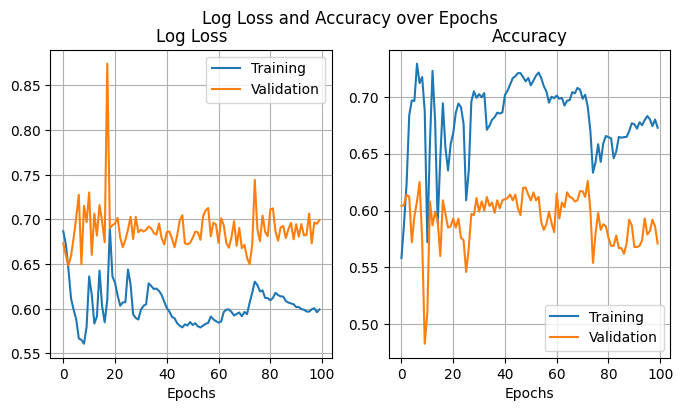

In [102]:
rnn_ebm.plot_loss_accuracy()

In [103]:
rnn_ebm_split = comp.test_split_ratio(dataset,
                                      "RNN",
                                      "EBM",
                                      learning_rate=rnn_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=rnn_emb_params.iloc[-1]['params_epochs'],
                                      units=rnn_emb_params.iloc[-1]['params_units'],
                                      batch_size=rnn_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=rnn_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing split test for RNN, with embedding EBM.
Params: 0.05875428451650113, 100, 5
Test started.....
The result is: [(0.1, 0.561), (0.2, 0.5765), (0.3, 0.5767), (0.4, 0.5845), (0.5, 0.4736)]


In [104]:
rnn_ebm_vocab = comp.test_vocab_size(df,
                                      "RNN",
                                      "EBM",
                                      learning_rate=rnn_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=rnn_emb_params.iloc[-1]['params_epochs'],
                                      units=rnn_emb_params.iloc[-1]['params_units'],
                                      batch_size=rnn_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=rnn_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing vocab-size test for RNN, with embedding EBM.
Params: 0.05875428451650113, 100, 5
Test started........
The result is: [(1000, 0.5925), (2000, 0.5605), (3000, 0.5715), (4000, 0.6155), (5000, 0.5415), (6000, 0.5615), (7000, 0.622), (8000, 0.6095)]


In [105]:
reload(prd)
reload(dat)
reload(mlp)
reload(tb)
reload(comp)
reload(rnn)

<module 'source.recurent_neural_networks' from 'C:\\Python_files\\DL_final2\\source\\recurent_neural_networks.py'>

In [106]:
"""
2.4) LSTM with embedding encoding
"""
lstm_emb_params = rnn.find_best_rnn(X_train_EBM, Y_train_EBM, X_test_EBM, Y_test_EBM, n_trials=10, rnn_type="LSTM")
lstm_emb_params.to_pickle(r"checkpoints\lstm_emb_params.pkl")
# lstm_emb_params = pd.read_pickle("checkpoints\lstm_emb_params.pkl")

[I 2025-06-20 18:44:46,497] A new study created in memory with name: mlp_optimization


Epoch 1/116
20/20 [==============================] - 2s 22ms/step - loss: 0.6961 - accuracy: 0.5617 - val_loss: 0.6219 - val_accuracy: 0.6610
Epoch 2/116
20/20 [==============================] - 0s 5ms/step - loss: 0.5976 - accuracy: 0.6835 - val_loss: 0.6070 - val_accuracy: 0.6510
Epoch 3/116
20/20 [==============================] - 0s 5ms/step - loss: 0.5350 - accuracy: 0.7393 - val_loss: 0.6346 - val_accuracy: 0.6630
Epoch 4/116
20/20 [==============================] - 0s 5ms/step - loss: 0.4950 - accuracy: 0.7615 - val_loss: 0.6291 - val_accuracy: 0.6650
Epoch 5/116
20/20 [==============================] - 0s 5ms/step - loss: 0.4753 - accuracy: 0.7795 - val_loss: 0.6673 - val_accuracy: 0.6910
Epoch 6/116
20/20 [==============================] - 0s 5ms/step - loss: 0.4565 - accuracy: 0.7945 - val_loss: 0.6463 - val_accuracy: 0.6780
Epoch 7/116
20/20 [==============================] - 0s 5ms/step - loss: 0.4428 - accuracy: 0.8012 - val_loss: 0.6567 - val_accuracy: 0.6660
Epoch 8/116


[I 2025-06-20 18:44:59,754] Trial 0 finished with values: [0.7034182548522949, 0.6672000288963318] and parameters: {'epochs': 116, 'learning_rate': 0.2055399152543681, 'units': 10, 'two_layers': True, 'batch_size': 208}.


Epoch 1/121
44/44 [==============================] - 1s 7ms/step - loss: 0.6661 - accuracy: 0.5950 - val_loss: 0.5923 - val_accuracy: 0.6720
Epoch 2/121
44/44 [==============================] - 0s 2ms/step - loss: 0.5486 - accuracy: 0.7237 - val_loss: 0.5836 - val_accuracy: 0.6970
Epoch 3/121
44/44 [==============================] - 0s 2ms/step - loss: 0.4953 - accuracy: 0.7670 - val_loss: 0.6130 - val_accuracy: 0.6820
Epoch 4/121
44/44 [==============================] - 0s 2ms/step - loss: 0.4710 - accuracy: 0.7883 - val_loss: 0.6227 - val_accuracy: 0.6880
Epoch 5/121
44/44 [==============================] - 0s 2ms/step - loss: 0.4558 - accuracy: 0.7990 - val_loss: 0.6483 - val_accuracy: 0.6890
Epoch 6/121
44/44 [==============================] - 0s 2ms/step - loss: 0.4485 - accuracy: 0.8055 - val_loss: 0.6796 - val_accuracy: 0.6870
Epoch 7/121
44/44 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.8087 - val_loss: 0.6774 - val_accuracy: 0.6820
Epoch 8/121
4

[I 2025-06-20 18:45:13,024] Trial 1 finished with values: [1.2262340784072876, 0.6435999870300293] and parameters: {'epochs': 121, 'learning_rate': 0.017745745390812216, 'units': 8, 'two_layers': False, 'batch_size': 92}.


Epoch 1/178
24/24 [==============================] - 2s 17ms/step - loss: 0.6846 - accuracy: 0.5713 - val_loss: 0.6716 - val_accuracy: 0.6040
Epoch 2/178
24/24 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5753 - val_loss: 0.6723 - val_accuracy: 0.6040
Epoch 3/178
24/24 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5753 - val_loss: 0.6729 - val_accuracy: 0.6040
Epoch 4/178
24/24 [==============================] - 0s 4ms/step - loss: 0.6827 - accuracy: 0.5753 - val_loss: 0.6717 - val_accuracy: 0.6040
Epoch 5/178
24/24 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5753 - val_loss: 0.6715 - val_accuracy: 0.6040
Epoch 6/178
24/24 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.5753 - val_loss: 0.6716 - val_accuracy: 0.6040
Epoch 7/178
24/24 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5753 - val_loss: 0.6818 - val_accuracy: 0.6040
Epoch 8/178


[I 2025-06-20 18:45:31,376] Trial 2 finished with values: [0.6910253763198853, 0.5547999739646912] and parameters: {'epochs': 178, 'learning_rate': 0.27930245481959076, 'units': 2, 'two_layers': True, 'batch_size': 167}.


Epoch 1/193
18/18 [==============================] - 2s 23ms/step - loss: 0.6858 - accuracy: 0.5695 - val_loss: 0.6649 - val_accuracy: 0.6040
Epoch 2/193
18/18 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6370 - val_loss: 0.6094 - val_accuracy: 0.6690
Epoch 3/193
18/18 [==============================] - 0s 4ms/step - loss: 0.5758 - accuracy: 0.7128 - val_loss: 0.6076 - val_accuracy: 0.6830
Epoch 4/193
18/18 [==============================] - 0s 4ms/step - loss: 0.5372 - accuracy: 0.7470 - val_loss: 0.6650 - val_accuracy: 0.6410
Epoch 5/193
18/18 [==============================] - 0s 4ms/step - loss: 0.5424 - accuracy: 0.7423 - val_loss: 0.6250 - val_accuracy: 0.6770
Epoch 6/193
18/18 [==============================] - 0s 4ms/step - loss: 0.5127 - accuracy: 0.7673 - val_loss: 0.6265 - val_accuracy: 0.6660
Epoch 7/193
18/18 [==============================] - 0s 4ms/step - loss: 0.4926 - accuracy: 0.7843 - val_loss: 0.6395 - val_accuracy: 0.6710
Epoch 8/193


[I 2025-06-20 18:45:47,301] Trial 3 finished with values: [0.6623809933662415, 0.6725999712944031] and parameters: {'epochs': 193, 'learning_rate': 0.17454698761619508, 'units': 2, 'two_layers': True, 'batch_size': 231}.


Epoch 1/155
30/30 [==============================] - 1s 9ms/step - loss: 0.6952 - accuracy: 0.5715 - val_loss: 0.6762 - val_accuracy: 0.6240
Epoch 2/155
30/30 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6045 - val_loss: 0.6522 - val_accuracy: 0.6120
Epoch 3/155
30/30 [==============================] - 0s 3ms/step - loss: 0.6062 - accuracy: 0.6620 - val_loss: 0.6246 - val_accuracy: 0.6460
Epoch 4/155
30/30 [==============================] - 0s 3ms/step - loss: 0.5770 - accuracy: 0.7028 - val_loss: 0.6370 - val_accuracy: 0.6520
Epoch 5/155
30/30 [==============================] - 0s 2ms/step - loss: 0.5451 - accuracy: 0.7308 - val_loss: 0.6975 - val_accuracy: 0.6330
Epoch 6/155
30/30 [==============================] - 0s 3ms/step - loss: 0.5143 - accuracy: 0.7520 - val_loss: 0.6508 - val_accuracy: 0.6640
Epoch 7/155
30/30 [==============================] - 0s 3ms/step - loss: 0.5157 - accuracy: 0.7530 - val_loss: 0.6304 - val_accuracy: 0.6790
Epoch 8/155
3

[I 2025-06-20 18:46:00,332] Trial 4 finished with values: [0.6548164486885071, 0.6660000085830688] and parameters: {'epochs': 155, 'learning_rate': 0.27836917203357686, 'units': 10, 'two_layers': False, 'batch_size': 135}.


Epoch 1/151
22/22 [==============================] - 1s 12ms/step - loss: 0.6863 - accuracy: 0.5617 - val_loss: 0.6801 - val_accuracy: 0.5720
Epoch 2/151
22/22 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6525 - val_loss: 0.6168 - val_accuracy: 0.6550
Epoch 3/151
22/22 [==============================] - 0s 3ms/step - loss: 0.5418 - accuracy: 0.7340 - val_loss: 0.6072 - val_accuracy: 0.6730
Epoch 4/151
22/22 [==============================] - 0s 3ms/step - loss: 0.4886 - accuracy: 0.7713 - val_loss: 0.6487 - val_accuracy: 0.6710
Epoch 5/151
22/22 [==============================] - 0s 3ms/step - loss: 0.4542 - accuracy: 0.7943 - val_loss: 0.6465 - val_accuracy: 0.6550
Epoch 6/151
22/22 [==============================] - 0s 3ms/step - loss: 0.4530 - accuracy: 0.7935 - val_loss: 0.6776 - val_accuracy: 0.6770
Epoch 7/151
22/22 [==============================] - 0s 3ms/step - loss: 0.4425 - accuracy: 0.8065 - val_loss: 0.7338 - val_accuracy: 0.6670
Epoch 8/151


[I 2025-06-20 18:46:10,629] Trial 5 finished with values: [0.761750340461731, 0.6592000126838684] and parameters: {'epochs': 151, 'learning_rate': 0.22359191551357038, 'units': 9, 'two_layers': False, 'batch_size': 182}.


Epoch 1/151
33/33 [==============================] - 2s 14ms/step - loss: 0.6691 - accuracy: 0.5915 - val_loss: 0.6427 - val_accuracy: 0.6370
Epoch 2/151
33/33 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6497 - val_loss: 0.6381 - val_accuracy: 0.6550
Epoch 3/151
33/33 [==============================] - 0s 4ms/step - loss: 0.6213 - accuracy: 0.6622 - val_loss: 0.6445 - val_accuracy: 0.6370
Epoch 4/151
33/33 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6758 - val_loss: 0.6433 - val_accuracy: 0.6470
Epoch 5/151
33/33 [==============================] - 0s 4ms/step - loss: 0.5731 - accuracy: 0.7140 - val_loss: 0.6529 - val_accuracy: 0.6640
Epoch 6/151
33/33 [==============================] - 0s 4ms/step - loss: 0.5593 - accuracy: 0.7182 - val_loss: 0.6090 - val_accuracy: 0.6790
Epoch 7/151
33/33 [==============================] - 0s 4ms/step - loss: 0.5470 - accuracy: 0.7355 - val_loss: 0.6389 - val_accuracy: 0.6570
Epoch 8/151


[I 2025-06-20 18:46:33,007] Trial 6 finished with values: [0.662059485912323, 0.6592000126838684] and parameters: {'epochs': 151, 'learning_rate': 0.3095602644475415, 'units': 4, 'two_layers': True, 'batch_size': 123}.


Epoch 1/119
22/22 [==============================] - 2s 19ms/step - loss: 0.6830 - accuracy: 0.5695 - val_loss: 0.6686 - val_accuracy: 0.6040
Epoch 2/119
22/22 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.6108 - val_loss: 0.6620 - val_accuracy: 0.6280
Epoch 3/119
22/22 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6237 - val_loss: 0.6436 - val_accuracy: 0.5940
Epoch 4/119
22/22 [==============================] - 0s 4ms/step - loss: 0.6074 - accuracy: 0.6695 - val_loss: 0.6434 - val_accuracy: 0.6080
Epoch 5/119
22/22 [==============================] - 0s 4ms/step - loss: 0.6004 - accuracy: 0.6810 - val_loss: 0.6309 - val_accuracy: 0.6380
Epoch 6/119
22/22 [==============================] - 0s 4ms/step - loss: 0.6024 - accuracy: 0.6600 - val_loss: 0.6481 - val_accuracy: 0.5970
Epoch 7/119
22/22 [==============================] - 0s 4ms/step - loss: 0.5942 - accuracy: 0.6625 - val_loss: 0.6660 - val_accuracy: 0.6080
Epoch 8/119


[I 2025-06-20 18:46:45,928] Trial 7 finished with values: [0.6607932448387146, 0.614799976348877] and parameters: {'epochs': 119, 'learning_rate': 0.3302690222716229, 'units': 2, 'two_layers': True, 'batch_size': 185}.


Epoch 1/170
24/24 [==============================] - 1s 11ms/step - loss: 0.6979 - accuracy: 0.5725 - val_loss: 0.6590 - val_accuracy: 0.6240
Epoch 2/170
24/24 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.6750 - val_loss: 0.6220 - val_accuracy: 0.6590
Epoch 3/170
24/24 [==============================] - 0s 3ms/step - loss: 0.5534 - accuracy: 0.7372 - val_loss: 0.6838 - val_accuracy: 0.6320
Epoch 4/170
24/24 [==============================] - 0s 3ms/step - loss: 0.5222 - accuracy: 0.7530 - val_loss: 0.7109 - val_accuracy: 0.6190
Epoch 5/170
24/24 [==============================] - 0s 3ms/step - loss: 0.4961 - accuracy: 0.7688 - val_loss: 0.6406 - val_accuracy: 0.6500
Epoch 6/170
24/24 [==============================] - 0s 3ms/step - loss: 0.4716 - accuracy: 0.7930 - val_loss: 0.6703 - val_accuracy: 0.6570
Epoch 7/170
24/24 [==============================] - 0s 3ms/step - loss: 0.4594 - accuracy: 0.7975 - val_loss: 0.6722 - val_accuracy: 0.6620
Epoch 8/170


[I 2025-06-20 18:46:58,784] Trial 8 finished with values: [0.7219505906105042, 0.6682000160217285] and parameters: {'epochs': 170, 'learning_rate': 0.2334996210140691, 'units': 9, 'two_layers': False, 'batch_size': 173}.


Epoch 1/166
32/32 [==============================] - 1s 8ms/step - loss: 0.6959 - accuracy: 0.5585 - val_loss: 0.6704 - val_accuracy: 0.6220
Epoch 2/166
32/32 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.5982 - val_loss: 0.6420 - val_accuracy: 0.6220
Epoch 3/166
32/32 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6490 - val_loss: 0.6590 - val_accuracy: 0.6030
Epoch 4/166
32/32 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6733 - val_loss: 0.6979 - val_accuracy: 0.5940
Epoch 5/166
32/32 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.6697 - val_loss: 0.6576 - val_accuracy: 0.5980
Epoch 6/166
32/32 [==============================] - 0s 3ms/step - loss: 0.6051 - accuracy: 0.6862 - val_loss: 0.6794 - val_accuracy: 0.5900
Epoch 7/166
32/32 [==============================] - 0s 3ms/step - loss: 0.6054 - accuracy: 0.6858 - val_loss: 0.7164 - val_accuracy: 0.5640
Epoch 8/166
3

[I 2025-06-20 18:47:13,393] Trial 9 finished with values: [0.648389458656311, 0.6320000290870667] and parameters: {'epochs': 166, 'learning_rate': 0.3670709586937087, 'units': 7, 'two_layers': False, 'batch_size': 127}.


In [107]:
lstm_emb_params

,loss,accuracy,params_batch_size,params_epochs,params_learning_rate,params_two_layers,params_units,time,trial_time,name
0,0.691025,0.5548,167,178,0.279302,True,2,18.352022,18.352022,LSTM_EBM
1,0.660793,0.6148,185,119,0.330269,True,2,12.919952,12.919952,LSTM_EBM
2,0.648389,0.6320,127,166,0.367071,False,7,14.606800,14.606800,LSTM_EBM
3,1.226234,0.6436,92,121,0.017746,False,8,13.268863,13.268863,LSTM_EBM
4,0.662059,0.6592,123,151,0.309560,True,4,22.377339,22.377339,LSTM_EBM
5,0.761750,0.6592,182,151,0.223592,False,9,10.296605,10.296605,LSTM_EBM
6,0.654816,0.6660,135,155,0.278369,False,10,13.029650,13.029650,LSTM_EBM
7,0.703418,0.6672,208,116,0.205540,True,10,13.257080,13.257080,LSTM_EBM
8,0.721951,0.6682,173,170,0.233500,False,9,12.855194,12.855194,LSTM_EBM
9,0.662381,0.6726,231,193,0.174547,True,2,15.924047,15.924047,LSTM_EBM


In [108]:
lstm_ebm = rnn.Recurrent_Model(X=X_train_EBM,
                              Y=Y_train_EBM,
                              input_dim=1004,
                              output_dim=1,
                              units=lstm_emb_params.iloc[-1]['params_units'],
                              rnn_type="LSTM",
                              two_layers=lstm_emb_params.iloc[-1]['params_two_layers'])



Epoch 1/193
18/18 [==============================] - 2s 22ms/step - loss: 0.6724 - accuracy: 0.5890 - val_loss: 0.6312 - val_accuracy: 0.6540
Epoch 2/193
18/18 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6597 - val_loss: 0.6277 - val_accuracy: 0.6390
Epoch 3/193
18/18 [==============================] - 0s 4ms/step - loss: 0.5879 - accuracy: 0.7080 - val_loss: 0.6250 - val_accuracy: 0.6770
Epoch 4/193
18/18 [==============================] - 0s 4ms/step - loss: 0.5624 - accuracy: 0.7297 - val_loss: 0.6183 - val_accuracy: 0.6650
Epoch 5/193
18/18 [==============================] - 0s 4ms/step - loss: 0.5389 - accuracy: 0.7535 - val_loss: 0.6263 - val_accuracy: 0.6620
Epoch 6/193
18/18 [==============================] - 0s 4ms/step - loss: 0.5289 - accuracy: 0.7567 - val_loss: 0.6457 - val_accuracy: 0.6660
Epoch 7/193
18/18 [==============================] - 0s 4ms/step - loss: 0.5042 - accuracy: 0.7730 - val_loss: 0.6402 - val_accuracy: 0.6730
Epoch 8/193


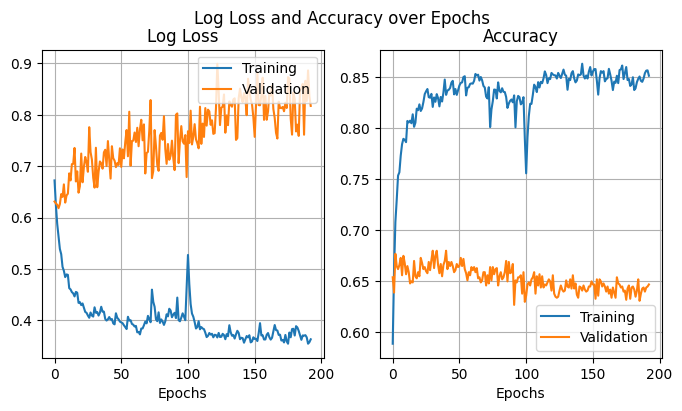

In [109]:
lstm_ebm.train(LR=lstm_emb_params.iloc[-1]['params_learning_rate'],
              epochs=lstm_emb_params.iloc[-1]['params_epochs'],
              batch_size=lstm_emb_params.iloc[-1]['params_batch_size'],
              verbose=1,
              validation_split=0.2)

lstm_ebm.plot_loss_accuracy()


In [110]:
lstm_ebm_split = comp.test_split_ratio(dataset,
                                      "LSTM",
                                      "EBM",
                                      learning_rate=lstm_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=lstm_emb_params.iloc[-1]['params_epochs'],
                                      units=lstm_emb_params.iloc[-1]['params_units'],
                                      batch_size=lstm_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=lstm_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing split test for LSTM, with embedding EBM.
Params: 0.17454698761619508, 193, 2
Test started.....
The result is: [(0.1, 0.583), (0.2, 0.585), (0.3, 0.581), (0.4, 0.6755), (0.5, 0.6696)]


In [111]:
lstm_ebm_vocab = comp.test_vocab_size(df,
                                      "LSTM",
                                      "EBM",
                                      learning_rate=lstm_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=lstm_emb_params.iloc[-1]['params_epochs'],
                                      units=lstm_emb_params.iloc[-1]['params_units'],
                                      batch_size=lstm_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=lstm_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing vocab-size test for LSTM, with embedding EBM.
Params: 0.17454698761619508, 193, 2
Test started........
The result is: [(1000, 0.6635), (2000, 0.672), (3000, 0.6235), (4000, 0.651), (5000, 0.6835), (6000, 0.6055), (7000, 0.664), (8000, 0.678)]


In [112]:
"""
2.5) GRU with embedding encoding
"""
gru_emb_params = rnn.find_best_rnn(X_train_EBM, Y_train_EBM, X_test_EBM, Y_test_EBM, n_trials=10, rnn_type="GRU")
gru_emb_params.to_pickle(r"checkpoints\gru_emb_params.pkl")
# gru_emb_params = pd.read_pickle("checkpoints\gru_emb_params.pkl")

[I 2025-06-20 18:51:46,583] A new study created in memory with name: mlp_optimization


Epoch 1/135
17/17 [==============================] - 1s 14ms/step - loss: 0.6775 - accuracy: 0.5710 - val_loss: 0.6465 - val_accuracy: 0.6290
Epoch 2/135
17/17 [==============================] - 0s 3ms/step - loss: 0.5821 - accuracy: 0.7020 - val_loss: 0.5923 - val_accuracy: 0.6720
Epoch 3/135
17/17 [==============================] - 0s 3ms/step - loss: 0.5072 - accuracy: 0.7582 - val_loss: 0.6301 - val_accuracy: 0.6640
Epoch 4/135
17/17 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.7905 - val_loss: 0.6624 - val_accuracy: 0.6510
Epoch 5/135
17/17 [==============================] - 0s 3ms/step - loss: 0.4430 - accuracy: 0.8023 - val_loss: 0.6711 - val_accuracy: 0.6710
Epoch 6/135
17/17 [==============================] - 0s 3ms/step - loss: 0.4384 - accuracy: 0.8092 - val_loss: 0.6815 - val_accuracy: 0.6540
Epoch 7/135
17/17 [==============================] - 0s 3ms/step - loss: 0.4340 - accuracy: 0.8073 - val_loss: 0.7128 - val_accuracy: 0.6440
Epoch 8/135


[I 2025-06-20 18:51:54,590] Trial 0 finished with values: [0.8326531052589417, 0.6552000045776367] and parameters: {'epochs': 135, 'learning_rate': 0.24809679710973007, 'units': 2, 'two_layers': False, 'batch_size': 242}.


Epoch 1/115
55/55 [==============================] - 2s 9ms/step - loss: 0.6742 - accuracy: 0.5918 - val_loss: 0.6318 - val_accuracy: 0.6520
Epoch 2/115
55/55 [==============================] - 0s 3ms/step - loss: 0.5806 - accuracy: 0.6888 - val_loss: 0.5960 - val_accuracy: 0.6710
Epoch 3/115
55/55 [==============================] - 0s 3ms/step - loss: 0.5162 - accuracy: 0.7470 - val_loss: 0.6206 - val_accuracy: 0.6740
Epoch 4/115
55/55 [==============================] - 0s 3ms/step - loss: 0.4920 - accuracy: 0.7692 - val_loss: 0.6157 - val_accuracy: 0.6830
Epoch 5/115
55/55 [==============================] - 0s 3ms/step - loss: 0.4627 - accuracy: 0.7805 - val_loss: 0.6684 - val_accuracy: 0.6540
Epoch 6/115
55/55 [==============================] - 0s 3ms/step - loss: 0.4569 - accuracy: 0.7883 - val_loss: 0.6635 - val_accuracy: 0.6580
Epoch 7/115
55/55 [==============================] - 0s 3ms/step - loss: 0.4349 - accuracy: 0.8043 - val_loss: 0.7504 - val_accuracy: 0.6360
Epoch 8/115
5

[I 2025-06-20 18:52:17,887] Trial 1 finished with values: [0.95840984582901, 0.6664000153541565] and parameters: {'epochs': 115, 'learning_rate': 0.0535407301886092, 'units': 8, 'two_layers': True, 'batch_size': 74}.


Epoch 1/194
16/16 [==============================] - 1s 15ms/step - loss: 0.6815 - accuracy: 0.5735 - val_loss: 0.6667 - val_accuracy: 0.6040
Epoch 2/194
16/16 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.5888 - val_loss: 0.6541 - val_accuracy: 0.6370
Epoch 3/194
16/16 [==============================] - 0s 3ms/step - loss: 0.6060 - accuracy: 0.6793 - val_loss: 0.5869 - val_accuracy: 0.6870
Epoch 4/194
16/16 [==============================] - 0s 3ms/step - loss: 0.5300 - accuracy: 0.7398 - val_loss: 0.5862 - val_accuracy: 0.6850
Epoch 5/194
16/16 [==============================] - 0s 3ms/step - loss: 0.4813 - accuracy: 0.7720 - val_loss: 0.6051 - val_accuracy: 0.6910
Epoch 6/194
16/16 [==============================] - 0s 3ms/step - loss: 0.4560 - accuracy: 0.7862 - val_loss: 0.6205 - val_accuracy: 0.6800
Epoch 7/194
16/16 [==============================] - 0s 3ms/step - loss: 0.4415 - accuracy: 0.8023 - val_loss: 0.6574 - val_accuracy: 0.6900
Epoch 8/194


[I 2025-06-20 18:52:28,661] Trial 2 finished with values: [1.02829110622406, 0.65420001745224] and parameters: {'epochs': 194, 'learning_rate': 0.012168909097988154, 'units': 7, 'two_layers': False, 'batch_size': 255}.


Epoch 1/129
18/18 [==============================] - 2s 13ms/step - loss: 0.6934 - accuracy: 0.5565 - val_loss: 0.6704 - val_accuracy: 0.6040
Epoch 2/129
18/18 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6115 - val_loss: 0.6415 - val_accuracy: 0.6430
Epoch 3/129
18/18 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6630 - val_loss: 0.6210 - val_accuracy: 0.6620
Epoch 4/129
18/18 [==============================] - 0s 3ms/step - loss: 0.6005 - accuracy: 0.6877 - val_loss: 0.6241 - val_accuracy: 0.6690
Epoch 5/129
18/18 [==============================] - 0s 3ms/step - loss: 0.6086 - accuracy: 0.6793 - val_loss: 0.6353 - val_accuracy: 0.6710
Epoch 6/129
18/18 [==============================] - 0s 3ms/step - loss: 0.5937 - accuracy: 0.6957 - val_loss: 0.6452 - val_accuracy: 0.6660
Epoch 7/129
18/18 [==============================] - 0s 3ms/step - loss: 0.5937 - accuracy: 0.6880 - val_loss: 0.6385 - val_accuracy: 0.6720
Epoch 8/129


[I 2025-06-20 18:52:37,228] Trial 3 finished with values: [0.6780109405517578, 0.5906000137329102] and parameters: {'epochs': 129, 'learning_rate': 0.38507127893376086, 'units': 2, 'two_layers': False, 'batch_size': 226}.


Epoch 1/127
112/112 [==============================] - 1s 4ms/step - loss: 0.6706 - accuracy: 0.5932 - val_loss: 0.6237 - val_accuracy: 0.6340
Epoch 2/127
112/112 [==============================] - 0s 2ms/step - loss: 0.6204 - accuracy: 0.6625 - val_loss: 0.6262 - val_accuracy: 0.6460
Epoch 3/127
112/112 [==============================] - 0s 2ms/step - loss: 0.5710 - accuracy: 0.7120 - val_loss: 0.6310 - val_accuracy: 0.6600
Epoch 4/127
112/112 [==============================] - 0s 2ms/step - loss: 0.5779 - accuracy: 0.7132 - val_loss: 0.6993 - val_accuracy: 0.6420
Epoch 5/127
112/112 [==============================] - 0s 2ms/step - loss: 0.5557 - accuracy: 0.7312 - val_loss: 0.6673 - val_accuracy: 0.6380
Epoch 6/127
112/112 [==============================] - 0s 2ms/step - loss: 0.5391 - accuracy: 0.7308 - val_loss: 0.6349 - val_accuracy: 0.6330
Epoch 7/127
112/112 [==============================] - 0s 2ms/step - loss: 0.5497 - accuracy: 0.7145 - val_loss: 0.7185 - val_accuracy: 0.5940

[I 2025-06-20 18:53:05,968] Trial 4 finished with values: [0.7013146877288818, 0.5809999704360962] and parameters: {'epochs': 127, 'learning_rate': 0.25548232642843693, 'units': 6, 'two_layers': False, 'batch_size': 36}.


Epoch 1/200
18/18 [==============================] - 2s 23ms/step - loss: 0.6870 - accuracy: 0.5535 - val_loss: 0.6662 - val_accuracy: 0.6040
Epoch 2/200
18/18 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6115 - val_loss: 0.6112 - val_accuracy: 0.6630
Epoch 3/200
18/18 [==============================] - 0s 4ms/step - loss: 0.5573 - accuracy: 0.7225 - val_loss: 0.5978 - val_accuracy: 0.6860
Epoch 4/200
18/18 [==============================] - 0s 4ms/step - loss: 0.5008 - accuracy: 0.7628 - val_loss: 0.6107 - val_accuracy: 0.6810
Epoch 5/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4873 - accuracy: 0.7688 - val_loss: 0.6560 - val_accuracy: 0.6690
Epoch 6/200
18/18 [==============================] - 0s 5ms/step - loss: 0.4476 - accuracy: 0.8050 - val_loss: 0.6587 - val_accuracy: 0.6830
Epoch 7/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4461 - accuracy: 0.8062 - val_loss: 0.6313 - val_accuracy: 0.6980
Epoch 8/200


[I 2025-06-20 18:53:23,982] Trial 5 finished with values: [0.8426028490066528, 0.6705999970436096] and parameters: {'epochs': 200, 'learning_rate': 0.04347806486846133, 'units': 4, 'two_layers': True, 'batch_size': 235}.


Epoch 1/165
26/26 [==============================] - 2s 16ms/step - loss: 0.7314 - accuracy: 0.5412 - val_loss: 0.6660 - val_accuracy: 0.6040
Epoch 2/165
26/26 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.5650 - val_loss: 0.6995 - val_accuracy: 0.6040
Epoch 3/165
26/26 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5660 - val_loss: 0.6657 - val_accuracy: 0.6040
Epoch 4/165
26/26 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.5670 - val_loss: 0.6730 - val_accuracy: 0.5180
Epoch 5/165
26/26 [==============================] - 0s 4ms/step - loss: 0.6731 - accuracy: 0.5685 - val_loss: 0.6619 - val_accuracy: 0.6040
Epoch 6/165
26/26 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5452 - val_loss: 0.6959 - val_accuracy: 0.4890
Epoch 7/165
26/26 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5550 - val_loss: 0.6618 - val_accuracy: 0.6040
Epoch 8/165


[I 2025-06-20 18:53:43,252] Trial 6 finished with values: [0.6861100196838379, 0.5809999704360962] and parameters: {'epochs': 165, 'learning_rate': 0.46049723693231204, 'units': 4, 'two_layers': True, 'batch_size': 159}.


Epoch 1/143
28/28 [==============================] - 1s 9ms/step - loss: 0.6678 - accuracy: 0.5870 - val_loss: 0.6168 - val_accuracy: 0.6540
Epoch 2/143
28/28 [==============================] - 0s 3ms/step - loss: 0.5632 - accuracy: 0.7095 - val_loss: 0.6037 - val_accuracy: 0.7020
Epoch 3/143
28/28 [==============================] - 0s 2ms/step - loss: 0.4964 - accuracy: 0.7688 - val_loss: 0.6252 - val_accuracy: 0.6680
Epoch 4/143
28/28 [==============================] - 0s 2ms/step - loss: 0.4683 - accuracy: 0.7885 - val_loss: 0.6355 - val_accuracy: 0.6850
Epoch 5/143
28/28 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.7868 - val_loss: 0.6991 - val_accuracy: 0.6520
Epoch 6/143
28/28 [==============================] - 0s 2ms/step - loss: 0.4391 - accuracy: 0.8150 - val_loss: 0.7276 - val_accuracy: 0.6630
Epoch 7/143
28/28 [==============================] - 0s 2ms/step - loss: 0.4288 - accuracy: 0.8158 - val_loss: 0.6899 - val_accuracy: 0.6690
Epoch 8/143
2

[I 2025-06-20 18:53:54,439] Trial 7 finished with values: [0.8960718512535095, 0.6593999862670898] and parameters: {'epochs': 143, 'learning_rate': 0.16996122785436352, 'units': 4, 'two_layers': False, 'batch_size': 147}.


Epoch 1/150
42/42 [==============================] - 2s 11ms/step - loss: 0.7069 - accuracy: 0.5443 - val_loss: 0.6814 - val_accuracy: 0.6040
Epoch 2/150
42/42 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5642 - val_loss: 0.7148 - val_accuracy: 0.4220
Epoch 3/150
42/42 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5655 - val_loss: 0.6794 - val_accuracy: 0.6040
Epoch 4/150
42/42 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5465 - val_loss: 0.6702 - val_accuracy: 0.6040
Epoch 5/150
42/42 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5630 - val_loss: 0.6646 - val_accuracy: 0.6040
Epoch 6/150
42/42 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5560 - val_loss: 0.6777 - val_accuracy: 0.4930
Epoch 7/150
42/42 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5623 - val_loss: 0.6716 - val_accuracy: 0.6040
Epoch 8/150


[I 2025-06-20 18:54:18,271] Trial 8 finished with values: [0.6946929693222046, 0.5809999704360962] and parameters: {'epochs': 150, 'learning_rate': 0.3276107598785436, 'units': 4, 'two_layers': True, 'batch_size': 97}.


Epoch 1/196
67/67 [==============================] - 2s 15ms/step - loss: 0.6632 - accuracy: 0.5922 - val_loss: 0.6082 - val_accuracy: 0.6730
Epoch 2/196
67/67 [==============================] - 0s 2ms/step - loss: 0.5599 - accuracy: 0.7072 - val_loss: 0.5855 - val_accuracy: 0.6940
Epoch 3/196
67/67 [==============================] - 0s 2ms/step - loss: 0.5010 - accuracy: 0.7640 - val_loss: 0.6259 - val_accuracy: 0.6760
Epoch 4/196
67/67 [==============================] - 0s 2ms/step - loss: 0.4786 - accuracy: 0.7815 - val_loss: 0.6330 - val_accuracy: 0.6680
Epoch 5/196
67/67 [==============================] - 0s 2ms/step - loss: 0.4496 - accuracy: 0.7987 - val_loss: 0.6390 - val_accuracy: 0.6750
Epoch 6/196
67/67 [==============================] - 0s 2ms/step - loss: 0.4405 - accuracy: 0.8077 - val_loss: 0.6653 - val_accuracy: 0.6690
Epoch 7/196
67/67 [==============================] - 0s 2ms/step - loss: 0.4292 - accuracy: 0.8160 - val_loss: 0.7131 - val_accuracy: 0.6730
Epoch 8/196


[I 2025-06-20 18:54:46,834] Trial 9 finished with values: [0.8952105641365051, 0.6610000133514404] and parameters: {'epochs': 196, 'learning_rate': 0.021936426226953593, 'units': 4, 'two_layers': False, 'batch_size': 60}.


In [113]:
gru_emb_params

,loss,accuracy,params_batch_size,params_epochs,params_learning_rate,params_two_layers,params_units,time,trial_time,name
0,0.686110,0.5810,159,165,0.460497,True,4,19.270825,19.270825,GRU_EBM
1,0.694693,0.5810,97,150,0.327611,True,4,23.831577,23.831577,GRU_EBM
2,0.701315,0.5810,36,127,0.255482,False,6,28.738764,28.738764,GRU_EBM
3,0.678011,0.5906,226,129,0.385071,False,2,8.567064,8.567064,GRU_EBM
4,1.028291,0.6542,255,194,0.012169,False,7,10.773158,10.773158,GRU_EBM
5,0.832653,0.6552,242,135,0.248097,False,2,8.006246,8.006246,GRU_EBM
6,0.896072,0.6594,147,143,0.169961,False,4,11.185275,11.185275,GRU_EBM
7,0.895211,0.6610,60,196,0.021936,False,4,28.562601,28.562601,GRU_EBM
8,0.958410,0.6664,74,115,0.053541,True,8,23.295808,23.295808,GRU_EBM
9,0.842603,0.6706,235,200,0.043478,True,4,18.012343,18.012343,GRU_EBM


Epoch 1/200
18/18 [==============================] - 2s 22ms/step - loss: 0.6858 - accuracy: 0.5652 - val_loss: 0.6691 - val_accuracy: 0.6040
Epoch 2/200
18/18 [==============================] - 0s 4ms/step - loss: 0.6667 - accuracy: 0.5997 - val_loss: 0.6421 - val_accuracy: 0.6430
Epoch 3/200
18/18 [==============================] - 0s 5ms/step - loss: 0.5906 - accuracy: 0.6942 - val_loss: 0.6040 - val_accuracy: 0.6730
Epoch 4/200
18/18 [==============================] - 0s 4ms/step - loss: 0.5361 - accuracy: 0.7385 - val_loss: 0.5984 - val_accuracy: 0.6890
Epoch 5/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4822 - accuracy: 0.7772 - val_loss: 0.6242 - val_accuracy: 0.6830
Epoch 6/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4520 - accuracy: 0.7962 - val_loss: 0.6520 - val_accuracy: 0.6790
Epoch 7/200
18/18 [==============================] - 0s 4ms/step - loss: 0.4415 - accuracy: 0.8040 - val_loss: 0.6804 - val_accuracy: 0.6760
Epoch 8/200


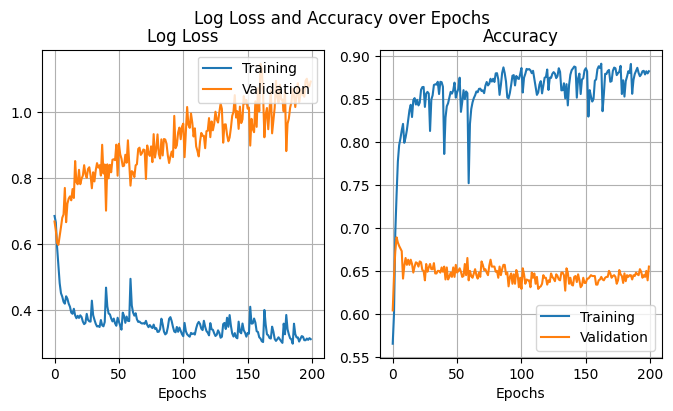

In [114]:
gru_ebm = rnn.Recurrent_Model(X=X_train_EBM,
                              Y=Y_train_EBM,
                              input_dim=1004,
                              output_dim=1,
                              units=gru_emb_params.iloc[-1]['params_units'],
                              rnn_type="GRU",
                              two_layers=gru_emb_params.iloc[-1]['params_two_layers'])

gru_ebm.train(LR=gru_emb_params.iloc[-1]['params_learning_rate'],
              epochs=gru_emb_params.iloc[-1]['params_epochs'],
              batch_size=gru_emb_params.iloc[-1]['params_batch_size'],
              verbose=1,
              validation_split=0.2)

gru_ebm.plot_loss_accuracy()

In [115]:
gru_ebm_split = comp.test_split_ratio(dataset,
                                      "GRU",
                                      "EBM",
                                      learning_rate=gru_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=gru_emb_params.iloc[-1]['params_epochs'],
                                      units=gru_emb_params.iloc[-1]['params_units'],
                                      batch_size=gru_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=gru_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing split test for GRU, with embedding EBM.
Params: 0.04347806486846133, 200, 4
Test started.....
The result is: [(0.1, 0.687), (0.2, 0.6765), (0.3, 0.6577), (0.4, 0.6647), (0.5, 0.6712)]


In [116]:
gru_ebm_vocab = comp.test_vocab_size(df,
                                      "GRU",
                                      "EBM",
                                      learning_rate=gru_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=gru_emb_params.iloc[-1]['params_epochs'],
                                      units=gru_emb_params.iloc[-1]['params_units'],
                                      batch_size=gru_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=gru_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing vocab-size test for GRU, with embedding EBM.
Params: 0.04347806486846133, 200, 4
Test started........
The result is: [(1000, 0.682), (2000, 0.7025), (3000, 0.691), (4000, 0.6805), (5000, 0.6565), (6000, 0.665), (7000, 0.6695), (8000, 0.6285)]


In [117]:
"""
3) Upload data to the class for comparison
"""
table = tb.Table()
table.add_record(name="rnn_emb",
                 epoch=rnn_emb_params.iloc[-1]["params_epochs"],
                 lr=rnn_emb_params.iloc[-1]["params_learning_rate"],
                 accuracy=rnn_emb_params.iloc[-1]["accuracy"],
                 loss=rnn_emb_params.iloc[-1]["loss"],
                 units=rnn_emb_params.iloc[-1]["params_units"],
                 avg_time=rnn_emb_params.iloc[-1]["time"],
                 batch_size=rnn_emb_params.iloc[-1]["params_batch_size"],
                 two_layers=rnn_emb_params.iloc[-1]["params_two_layers"],
                 split_accuracy=rnn_ebm_split,
                 vocab_accuracy=rnn_ebm_vocab)

table.add_record(name="lstm_emb",
                 epoch=lstm_emb_params.iloc[-1]["params_epochs"],
                 lr=lstm_emb_params.iloc[-1]["params_learning_rate"],
                 accuracy=lstm_emb_params.iloc[-1]["accuracy"],
                 loss=lstm_emb_params.iloc[-1]["loss"],
                 units=lstm_emb_params.iloc[-1]["params_units"],
                 avg_time=lstm_emb_params.iloc[-1]["time"],
                 batch_size=lstm_emb_params.iloc[-1]["params_batch_size"],
                 two_layers=lstm_emb_params.iloc[-1]["params_two_layers"],
                 split_accuracy=lstm_ebm_split,
                 vocab_accuracy=lstm_ebm_vocab)

table.add_record(name="gru_emb",
                 epoch=gru_emb_params.iloc[-1]["params_epochs"],
                 lr=gru_emb_params.iloc[-1]["params_learning_rate"],
                 accuracy=gru_emb_params.iloc[-1]["accuracy"],
                 loss=gru_emb_params.iloc[-1]["loss"],
                 units=gru_emb_params.iloc[-1]["params_units"],
                 avg_time=gru_emb_params.iloc[-1]["time"],
                 batch_size=gru_emb_params.iloc[-1]["params_batch_size"],
                 two_layers=gru_emb_params.iloc[-1]["params_two_layers"],
                 split_accuracy=gru_ebm_split,
                 vocab_accuracy=gru_ebm_vocab)

table.add_record(name="mlp_tdidf",
                 epoch=mlp_tdidf_params.iloc[-1]["params_epochs"],
                 lr=mlp_tdidf_params.iloc[-1]["params_learning_rate"],
                 accuracy=mlp_tdidf_params.iloc[-1]["accuracy"],
                 loss=mlp_tdidf_params.iloc[-1]["loss"],
                 units=mlp_tdidf_params.iloc[-1]["params_units"],
                 avg_time=mlp_tdidf_params.iloc[-1]["time"],
                 split_accuracy=mlp_tdidf_split,
                 vocab_accuracy=mlp_tdidf_vocab)

table.add_record(name="mlp_bow",
                 epoch=mlp_bow_params.iloc[-1]["params_epochs"],
                 lr=mlp_bow_params.iloc[-1]["params_learning_rate"],
                 accuracy=mlp_bow_params.iloc[-1]["accuracy"],
                 loss=mlp_bow_params.iloc[-1]["loss"],
                 units=mlp_bow_params.iloc[-1]["params_units"],
                 avg_time=mlp_bow_params.iloc[-1]["time"],
                 split_accuracy=mlp_bow_split,
                 vocab_accuracy=mlp_bow_vocab)

Adding a new record with params: name: rnn_emb, epoch: 100, lr: 0.05875428451650113, units: 5, average time: 6.636226
Adding a new record with params: name: lstm_emb, epoch: 193, lr: 0.17454698761619508, units: 2, average time: 15.924047
Adding a new record with params: name: gru_emb, epoch: 200, lr: 0.04347806486846133, units: 4, average time: 18.012343
Adding a new record with params: name: mlp_tdidf, epoch: 200, lr: 0.045151405590688004, units: 7, average time: 29.877367
Adding a new record with params: name: mlp_bow, epoch: 146, lr: 0.023971889736978877, units: 9, average time: 16.646808


In [118]:
"""
4) Compare the results
"""
table.show(tabulate_view=False)


Table info:
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5 non-null      object 
 1   epochs          5 non-null      int64  
 2   accuracy        5 non-null      float64
 3   loss            5 non-null      float64
 4   lr              5 non-null      float64
 5   units           5 non-null      int64  
 6   avg_time        5 non-null      float64
 7   split_accuracy  5 non-null      object 
 8   vocab_accuracy  5 non-null      object 
 9   two_layers      5 non-null      int64  
 10  batch_size      5 non-null      int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 480.0+ bytes

Records preview:


,name,epochs,accuracy,loss,lr,units,avg_time,split_accuracy,vocab_accuracy,two_layers,batch_size
0,rnn_emb,100,0.5970,0.708684,0.058754,5,6.636226,"[(0.1, 0.561), (0.2, 0.5765), (0.3, 0.5767), (...","[(1000, 0.5925), (2000, 0.5605), (3000, 0.5715...",0,116
1,lstm_emb,193,0.6726,0.662381,0.174547,2,15.924047,"[(0.1, 0.583), (0.2, 0.585), (0.3, 0.581), (0....","[(1000, 0.6635), (2000, 0.672), (3000, 0.6235)...",1,231
2,gru_emb,200,0.6706,0.842603,0.043478,4,18.012343,"[(0.1, 0.687), (0.2, 0.6765), (0.3, 0.6577), (...","[(1000, 0.682), (2000, 0.7025), (3000, 0.691),...",1,235
3,mlp_tdidf,200,0.7305,0.533396,0.045151,7,29.877367,"[(0.1, 0.742), (0.2, 0.756), (0.3, 0.748), (0....","[(1000, 0.74), (2000, 0.7455), (3000, 0.7365),...",0,0
4,mlp_bow,146,0.7332,0.549288,0.023972,9,16.646808,"[(0.1, 0.746), (0.2, 0.733), (0.3, 0.7333), (0...","[(1000, 0.7385), (2000, 0.74), (3000, 0.738), ...",0,0


,name,epochs,accuracy,loss,lr,units,avg_time,split_accuracy,vocab_accuracy,two_layers,batch_size
0,rnn_emb,100,0.5970,0.708684,0.058754,5,6.636226,"[(0.1, 0.561), (0.2, 0.5765), (0.3, 0.5767), (...","[(1000, 0.5925), (2000, 0.5605), (3000, 0.5715...",0,116
1,lstm_emb,193,0.6726,0.662381,0.174547,2,15.924047,"[(0.1, 0.583), (0.2, 0.585), (0.3, 0.581), (0....","[(1000, 0.6635), (2000, 0.672), (3000, 0.6235)...",1,231
2,gru_emb,200,0.6706,0.842603,0.043478,4,18.012343,"[(0.1, 0.687), (0.2, 0.6765), (0.3, 0.6577), (...","[(1000, 0.682), (2000, 0.7025), (3000, 0.691),...",1,235
3,mlp_tdidf,200,0.7305,0.533396,0.045151,7,29.877367,"[(0.1, 0.742), (0.2, 0.756), (0.3, 0.748), (0....","[(1000, 0.74), (2000, 0.7455), (3000, 0.7365),...",0,0
4,mlp_bow,146,0.7332,0.549288,0.023972,9,16.646808,"[(0.1, 0.746), (0.2, 0.733), (0.3, 0.7333), (0...","[(1000, 0.7385), (2000, 0.74), (3000, 0.738), ...",0,0


In [119]:
table.print_best_accuracy()


Top 3 best accuracies:
1) 0.7332 for mlp_bow
2) 0.7305 for mlp_tdidf
3) 0.6726 for lstm_emb


In [120]:
all = tb.All_trials_table()
all.add_record(mlp_tdidf_params)
all.add_record(rnn_emb_params)
all.add_record(mlp_bow_params)
all.add_record(lstm_emb_params)
all.add_record(gru_emb_params)
all.show(tabulate_view=False)

Adding a new record with params.
Adding a new record with params.
Adding a new record with params.
Adding a new record with params.
Adding a new record with params.

Table info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loss                  50 non-null     float64
 1   accuracy              50 non-null     float64
 2   params_epochs         50 non-null     object 
 3   params_learning_rate  50 non-null     float64
 4   params_units          50 non-null     object 
 5   time                  50 non-null     float64
 6   trial_time            50 non-null     float64
 7   name                  50 non-null     object 
 8   params_batch_size     30 non-null     float64
 9   params_two_layers     30 non-null     object 
dtypes: float64(6), object(4)
memory usage: 4.0+ KB

Records preview:


C:\Python_files\DL_final2\source\table.py:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df =pd.concat([self.df, df], ignore_index=True)


,loss,accuracy,params_epochs,params_learning_rate,params_units,time,trial_time,name,params_batch_size,params_two_layers
0,0.966844,0.6795,132,0.382973,3,20.206940,20.206940,MLP_TDIDF,NaN,NaN
1,0.785470,0.6925,130,0.190014,7,19.763185,19.763185,MLP_TDIDF,NaN,NaN
2,0.955685,0.6980,143,0.351650,9,24.495364,24.495364,MLP_TDIDF,NaN,NaN
3,0.912543,0.7020,138,0.282411,6,21.133728,21.133728,MLP_TDIDF,NaN,NaN
4,0.754808,0.7075,106,0.244987,6,17.013422,17.013422,MLP_TDIDF,NaN,NaN
5,1.130622,0.7080,178,0.474013,4,26.121225,26.121225,MLP_TDIDF,NaN,NaN
6,0.644456,0.7095,166,0.104731,8,25.373619,25.373619,MLP_TDIDF,NaN,NaN
7,0.549058,0.7145,108,0.034657,4,16.308757,16.308757,MLP_TDIDF,NaN,NaN
8,0.615487,0.7160,111,0.140886,8,16.855306,16.855306,MLP_TDIDF,NaN,NaN
9,0.533396,0.7305,200,0.045151,7,29.877367,29.877367,MLP_TDIDF,NaN,NaN


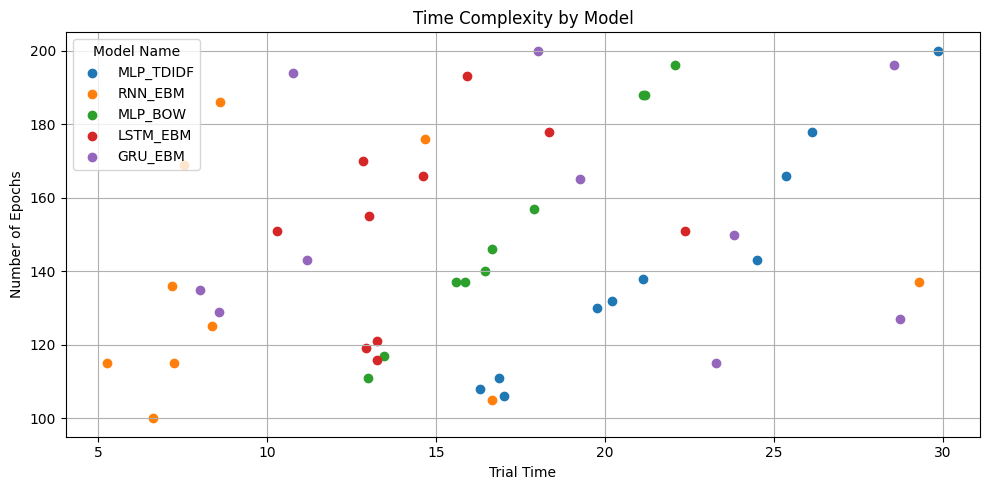

In [121]:
all.plot_time_complexity()

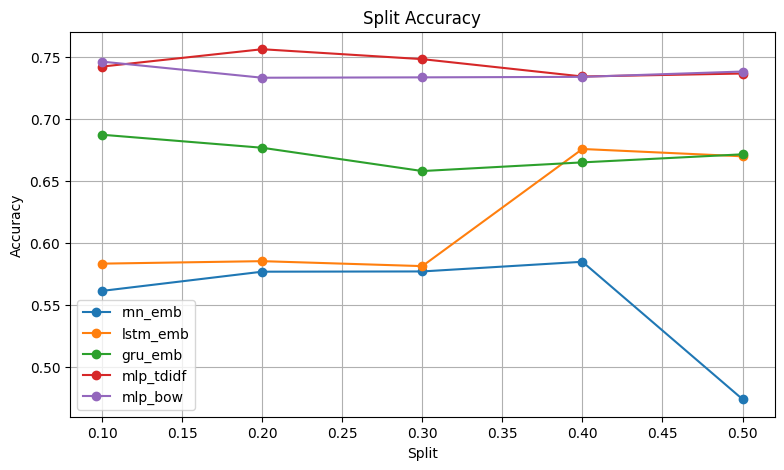

In [122]:
table.plot_split_accuracy()

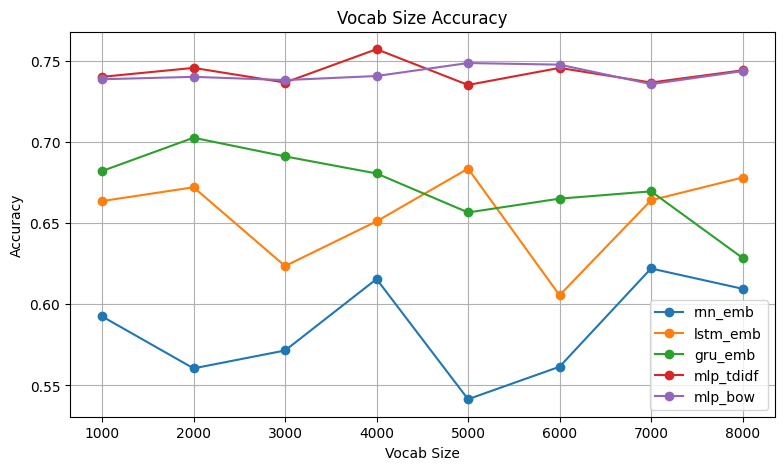

In [123]:
table.plot_vocab_accuracy()

In [124]:
from operator import itemgetter

summary = table.show(tabulate_view=False)
summary = summary.rename(columns={
    'name': 'Model',
    'epochs': 'Epochs',
    'accuracy': 'Accuracy',
    'loss': 'Loss',
    'lr': 'Learning rate',
    'units': 'Units',
    'avg_time': 'Average time of training',
    'two_layers': 'Has two layers?',
    'batch_size': 'Batch Size'
})

summary['Accuracy'] = round(summary['Accuracy'], 3)
summary['Loss'] = round(summary['Loss'], 3)
summary['Learning rate'] = round(summary['Learning rate'], 3)
summary['Average time of training'] = round(summary['Average time of training'], 3)

# from: https://www.tutorialspoint.com/maximum-element-in-tuple-list-in-python
best_splits = []
for row in summary['split_accuracy']:
    best = max(row, key=itemgetter(1))[0] if row else None
    best_splits.append(best)

summary['Best split-test'] = best_splits

best_vocabs = []
for row in summary['vocab_accuracy']:
    best = max(row, key=itemgetter(1))[0] if row else None
    best_vocabs.append(best)

summary['Has two layers?'] = summary['Has two layers?'].map({1: 'YES', 0: 'NO'})
summary['Best vocab size'] = best_vocabs
summary.drop(columns=['split_accuracy', 'vocab_accuracy'], inplace=True)
summary.sort_values(by=['Accuracy', "Loss"], ascending=False, inplace=True)
summary.set_index('Model', inplace=True)
summary.to_csv("summary.csv")
summary


Table info:
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5 non-null      object 
 1   epochs          5 non-null      int64  
 2   accuracy        5 non-null      float64
 3   loss            5 non-null      float64
 4   lr              5 non-null      float64
 5   units           5 non-null      int64  
 6   avg_time        5 non-null      float64
 7   split_accuracy  5 non-null      object 
 8   vocab_accuracy  5 non-null      object 
 9   two_layers      5 non-null      int64  
 10  batch_size      5 non-null      int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 480.0+ bytes

Records preview:


,name,epochs,accuracy,loss,lr,units,avg_time,split_accuracy,vocab_accuracy,two_layers,batch_size
0,rnn_emb,100,0.5970,0.708684,0.058754,5,6.636226,"[(0.1, 0.561), (0.2, 0.5765), (0.3, 0.5767), (...","[(1000, 0.5925), (2000, 0.5605), (3000, 0.5715...",0,116
1,lstm_emb,193,0.6726,0.662381,0.174547,2,15.924047,"[(0.1, 0.583), (0.2, 0.585), (0.3, 0.581), (0....","[(1000, 0.6635), (2000, 0.672), (3000, 0.6235)...",1,231
2,gru_emb,200,0.6706,0.842603,0.043478,4,18.012343,"[(0.1, 0.687), (0.2, 0.6765), (0.3, 0.6577), (...","[(1000, 0.682), (2000, 0.7025), (3000, 0.691),...",1,235
3,mlp_tdidf,200,0.7305,0.533396,0.045151,7,29.877367,"[(0.1, 0.742), (0.2, 0.756), (0.3, 0.748), (0....","[(1000, 0.74), (2000, 0.7455), (3000, 0.7365),...",0,0
4,mlp_bow,146,0.7332,0.549288,0.023972,9,16.646808,"[(0.1, 0.746), (0.2, 0.733), (0.3, 0.7333), (0...","[(1000, 0.7385), (2000, 0.74), (3000, 0.738), ...",0,0


,Epochs,Accuracy,Loss,Learning rate,Units,Average time of training,Has two layers?,Batch Size,Best split-test,Best vocab size
Model,,,,,,,,,,
mlp_bow,146,0.733,0.549,0.024,9,16.647,NO,0,0.1,5000
mlp_tdidf,200,0.730,0.533,0.045,7,29.877,NO,0,0.2,4000
lstm_emb,193,0.673,0.662,0.175,2,15.924,YES,231,0.4,5000
gru_emb,200,0.671,0.843,0.043,4,18.012,YES,235,0.1,2000
rnn_emb,100,0.597,0.709,0.059,5,6.636,NO,116,0.4,7000
